# Lab - Random Forests etc

# Lab: Random Forests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold 
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

pd.set_option('display.max_columns', None)

## Apply the Random Forests algorithm but this time only by upscaling the data.

In [2]:
cat = pd.read_csv("files_for_lab/categorical.csv")
num = pd.read_csv("files_for_lab/numerical.csv")
tar = pd.read_csv("files_for_lab/target.csv")

### Concatenate everything for a train-test split

In [3]:
df = pd.concat([cat, num, tar], axis = 1)

In [4]:
df

,STATE,CLUSTER,HOMEOWNR,GENDER,DATASRCE,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B,TARGET_D
0,IL,36,H,F,3,L,E,C,T,2,89,1,37,12,92,8,94,2,95,12,89,11,0,60.000000,5,9,0,0,39,34,18,10,2,1,5,992,264,332,0,35,65,47,53,92,1,0,0,11,0,0,0,0,0,0,0,11,0,0,0,39,48,51,40,50,54,25,31,42,27,11,14,18,17,13,11,15,12,11,34,25,18,26,10,23,18,33,49,28,12,4,61,7,12,19,198,276,97,95,2,2,0,0,7,7,0,479,635,3,2,86,14,96,4,7,38,80,70,32,84,16,6,2,5,9,15,3,17,50,25,0,0,0,2,7,13,27,47,0,1,61,58,61,15,4,2,0,0,14,1,0,0,2,5,17,73,0.0,177.0,682.0,307,318,349,378,12883,13,23,23,23,15,1,0,0,1,4,25,24,26,17,2,0,0,2,28,4,51,1,46,54,3,88,8,0,0,0,0,0,0,4,1,13,14,16,2,45,56,64,50,64,44,62,53,99,0,0,9,3,8,13,9,0,3,9,3,15,19,5,4,3,0,3,41,1,0,7,13,6,5,0,4,9,4,1,3,10,2,1,7,78,2,0,120,16,10,39,21,8,4,3,5,20,3,19,4,0,0,0,18,39,0,34,23,18,16,1,4,0,23,0,0,5,1,0,0,0,0,0,2,0,3,74,88,8,0,4,96,77,19,13,31,5,14,14,31,54,46,0,0,90,0,10,0,0,0,33,65,40,99,99,6,2,10,7,27,74,6,14,240.0,31,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39,0,0.0
1,CA,14,H,M,3,L,G,A,S,1,94,1,52,2,93,10,95,12,95,12,93,10,1,46.000000,6,9,16,0,15,55,11,6,2,1,9,3611,940,998,99,0,0,50,50,67,0,0,31,6,4,2,6,4,14,0,0,2,0,1,4,34,41,43,32,42,45,32,33,46,21,13,14,33,23,10,4,2,11,16,36,22,15,12,1,5,4,21,75,55,23,9,69,4,3,24,317,360,99,99,0,0,0,0,0,0,0,5468,5218,12,10,96,4,97,3,9,59,94,88,55,95,5,4,1,3,5,4,2,18,44,5,0,0,0,97,98,98,98,99,94,0,83,76,73,21,5,0,0,0,4,0,0,0,91,91,91,94,4480.0,13.0,803.0,1088,1096,1026,1037,36175,2,6,2,5,15,14,13,10,33,2,5,2,5,15,14,14,10,32,6,2,66,3,56,44,9,80,14,0,0,0,0,0,0,6,0,2,24,32,12,71,70,83,58,81,57,64,57,99,99,0,22,24,4,21,13,2,1,6,0,4,1,0,3,1,0,6,13,1,2,8,18,11,4,3,4,10,7,11,1,6,2,1,16,69,5,2,160,5,5,12,21,7,30,20,14,24,4,24,10,0,0,0,8,15,0,55,10,11,0,0,2,0,3,1,1,2,3,1,1,0,3,0,0,0,42,39,50,7,27,16,99,92,53,5,10,2,26,56,97,99,0,0,0,96,0,4,0,0,0,99,0,99,99,99,20,4,6,5,12,32,6,13,47.0,3,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1,0,0.0
2,NC,43,U,M,3,L,E,C,R,2,90,1,0,2,91,11,92,7,95,12,90,1,1,61.611649,3,1,2,0,20,29,33,6,8,1,1,7001,2040,2669,0,2,98,49,51,96,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,35,43,46,37,45,49,23,35,40,25,13,20,19,16,13,10,8,15,14,30,22,19,25,10

In [5]:

X = df.drop(['TARGET_B','TARGET_D'], axis = 1)

Y = pd.concat([df['TARGET_B'], df['TARGET_D']], axis = 1)

In [6]:
Y

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
95407,0,0.0
95408,0,0.0
95409,0,0.0
95410,1,18.0


### Train/test split

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

In [8]:
Y_train = Y_train.reset_index()

In [9]:
Y_test = Y_test.reset_index()

### num/cat split

In [10]:
num_train = X_train.select_dtypes(include = np.number)
num_test = X_test.select_dtypes(include = np.number)

In [11]:
cat_train = X_train.select_dtypes(include = object)
cat_test = X_test.select_dtypes(include = object)

In [12]:
len(num_test)

19083

### Encode categoricals

In [13]:
encoder = OneHotEncoder().fit(cat_train)

In [14]:
encoded_train = encoder.transform(cat_train).toarray()
encoded_test = encoder.transform(cat_test).toarray()

In [15]:
cat_train2 = pd.DataFrame(data=encoded_train, columns = encoder.get_feature_names_out())
cat_test2 = pd.DataFrame(data=encoded_test, columns = encoder.get_feature_names_out())

### Scale numericals

In [16]:
scaler = StandardScaler().fit(num_train)

In [17]:
scaled_train = scaler.transform(num_train)
scaled_test = scaler.transform(num_test)

In [18]:
num_train2 = pd.DataFrame(data=scaled_train, columns = num_train.columns)
num_test2 = pd.DataFrame(data=scaled_test, columns = num_train.columns)

### Re-concatenate

In [19]:
X_train = pd.concat([num_train2, cat_train2], axis = 1)

In [20]:
X_train.isna().sum().sum()

0

In [21]:
X_test = pd.concat([num_test2, cat_test2], axis = 1)

### And concatenate some more, in preparation for the oversampling

In [22]:
Xy = pd.concat([X_train, Y_train], axis = 1)

### Oversample

In [23]:
Xy0 = Xy[Xy['TARGET_B'] == 0]
Xy1 = Xy[Xy['TARGET_B'] == 1]

In [24]:
len(Xy0)

72447

In [25]:
len(Xy1)

3882

In [26]:
Xy1_new = resample(Xy1, n_samples = len(Xy0), replace = True)

In [27]:
traindata = pd.concat([Xy1_new, Xy0], axis = 0)

In [28]:
traindata = traindata.sample(frac = 1)

In [29]:
X_os = traindata.drop(["TARGET_B", "TARGET_D"], axis = 1)
Y_os = pd.concat([traindata['TARGET_B'], traindata["TARGET_D"]], axis = 1)

In [30]:
y_os = Y_os["TARGET_B"]
y_test = Y_test["TARGET_B"]

In [31]:
X_os.drop(columns = ["index"], inplace = True)
#Not sure how exactly this index column snuck in, but it needs to go.

### Now, the random forest:

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
randforest = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.6,
                             random_state = 111)
randforest.fit(X_os, y_os)

RandomForestClassifier(max_depth=5, max_samples=0.6, min_samples_leaf=20,
                       min_samples_split=20, random_state=111)

In [34]:
print(randforest.score(X_os, y_os))
print(randforest.score(X_test, y_test))

0.6203224426132207
0.6203427134098413


In [35]:
y_pred = randforest.predict(X_test)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0    18122
1      961
Name: TARGET_B, dtype: int64

array([[11336,  6786],
       [  459,   502]])

## Use Feature Selections that you have learned in class to decide if you want to use all of the features (PCA, etc)

I'm most intrigued by PCA as a process, so I'll try that first. 

First I'll set up a baseline by doing a logistic regression on the whole set.

### Prologue: logistic regression

In [36]:
reg = LogisticRegression().fit(X_os, y_os)

/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
reg.score(X_os, y_os)

0.6102461109500739

In [38]:
reg.score(X_test, y_test)

0.6102289996331813

### Chapter 1: PCA

In [39]:
from sklearn.decomposition import PCA

In [40]:
pca = PCA(n_components = 80)

In [41]:
pca.fit(X_os)

PCA(n_components=80)

In [42]:
pcatrans = pca.transform(X_os)

In [43]:
expl = pca.explained_variance_ratio_

In [44]:
expl_cumul = np.cumsum(expl)

<AxesSubplot:>

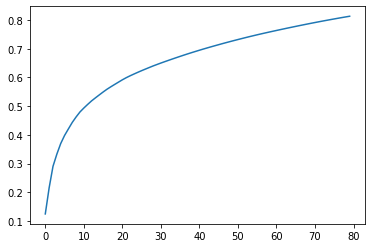

In [45]:
sns.lineplot(expl_cumul)

In [46]:
expl_cumul[70]

0.7916860192424218

By playing around with different values for n, I found that 80 PCAs will explain about 80% of the variance. That sounds like an OK trade-off, so I'll go with that for now.

In [47]:
pca2 = PCA(n_components = 70).fit(X_os)

In [48]:
pca2vals = pca2.transform(X_os)

In [49]:
pca_df = pd.DataFrame(data = pca2vals, columns = pca2.get_feature_names_out())

In [50]:
pca_df

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,pca50,pca51,pca52,pca53,pca54,pca55,pca56,pca57,pca58,pca59,pca60,pca61,pca62,pca63,pca64,pca65,pca66,pca67,pca68,pca69
0,8.197144,-3.588336,-0.605575,-1.689035,3.061665,-1.314072,0.210149,-2.381882,1.579983,-3.315252,-0.405697,-1.483793,-0.377136,1.634031,-1.304564,-1.373285,1.164451,1.395588,-0.939768,0.714328,-0.685847,-1.148396,0.337149,0.549458,0.015801,0.231711,0.824405,0.586702,-0.726726,-0.046977,-0.561290,-1.122527,-0.964581,1.124169,0.434221,1.149402,-0.617746,-0.028966,1.703329,-0.278219,-0.105100,1.055702,-0.753528,0.350132,0.269306,0.370573,0.319199,0.355603,0.589749,-0.687326,-0.328470,0.076286,1.102085,-0.008686,0.752306,0.023318,-0.150898,0.389546,0.346264,0.059438,0.680104,0.370216,0.852423,0.192302,0.113330,-0.238627,1.154849,-0.167774,-0.366407,-1.445966
1,0.490375,5.637709,-7.444378,-0.678840,-2.906076,2.649991,-2.759258,-4.208709,1.748656,-1.739216,0.332155,0.775488,-0.140312,-3.176443,-0.919238,1.454404,-0.838615,0.496357,2.274851,-2.985588,2.634271,1.134033,-0.943262,-0.926515,0.974079,-0.310445,-0.765178,-0.488846,-2.886005,-1.196328,0.548878,-1.199465,-0.674573,-0.420754,-1.063630,0.094198,0.386122,-0.320154,0.008838,-0.071786,-0.948162,0.285628,1.690782,0.080692,-0.394080,-0.061206,1.079125,0.446251,0.744366,0.470687,0.940643,0.588407,2.019583,1.381556,0.260937,-0.271554,-0.483118,-0.145605,0.662055,-0.462241,0.084138,-0.110760,0.549905,-0.193729,-0.652409,1.043541,-0.049593,1.770983,-0.461606,0.369386
2,-15.462410,0.369601,-2.251644,2.328689,7.147587,1.446094,2.867950,2.652058,-1.314693,-0.136759,0.229032,-1.328252,1.200670,-1.910145,0.270741,-0.623866,2.577514,1.230847,2.658389,-1.177550,0.390716,-0.064186,-2.056583,-0.507044,-0.126907,0.186049,0.869766,1.367291,-0.546305,0.336041,0.152441,-0.303121,0.405956,1.145453,1.196667,2.085397,0.599650,-0.372328,-1.189628,-2.093867,0.839182,0.866993,-0.203400,0.522658,1.397129,-1.479504,1.594168,-0.561571,-0.918986,-0.676480,-0.970624,1.372262,1.340358,-0.921407,1.037961,1.015969,-0.222404,1.081400,-0.934033,-0.350841,1.371968,0.337223,-0.705515,0.862736,-0.827016,0.002107,2.100213,0.859314,-1.351615,-1.239598
3,4.032924,-0.095369,-3.056722,-0.759963,-1.349343,-2.530388,-0.308180,-0.254898,-1.088219,-0.489065,-2.087324,-0.273865,-0.020603,2.340140,-1.846156,0.509906,0.069293,-0.231435,1.674392,-0.232289,0.687176,0.176447,-1.117909,-0.410591,1.385827,-1.307782,-2.768006,0.666856,0.912691,0.134822,-0.542732,0.761918,-0.246342,0.575730,1.117899,-0.427383,0.019258,-2.078046,0.294456,0.405446,1.111174,0.008382,0.809849,-1.025563,1.032693,1.057781,0.525691,-0.375088,0.229993,1.061455,0.067620,0.178916,-0.745342,1.583866,-0.784448,0.422565,0.520073,1.079738,-0.167219,-0.351158,0.374438,-0.002147,-0.437487,-0.433209,0.244883,0.238076,0.030722,-0.306877,0.290286,-0.532299
4,-10.751417,1.922864,-4.871537,0.767193,5.065513,-1.654542,0.145639,0.854179,1.959479,1.319983,1.760462,0.909301,-1.467595,-2.182462,1.530311,0.967718,1.368393,-0.095474,0.809974,0.458301,-0.757793,0.624352,-1.415483,-0.370048,0.925441,-1.881892,0.502124,0.153779,-0.756478,-0.478032,-0.795850,-0.472124,0.277678,-0.597473,-0.164616,-1.007783,0.730962,-2.243630,-0.770167,-0.461038,-1.270819,0.906778,2.050113,1.147633,0.878092,-0.255267,-1.195647,-0.257886,0.364776,0.747906,-0.880435,-0.769623,-0.185315,-0.587334,-0.328804,0.676093,-0.646574,-0.029836,0.145849,-0.009266,-0.934226,-0.194668,-0.081413,-1.144568,-0.706864,1.397699,1.038977,0.172177,-0.845096,0.100347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [51]:
# Treat the test data as well

In [52]:
pca2test = pca2.transform(X_test)

In [53]:
reg_pca = LogisticRegression().fit(pca_df, y_os)

In [54]:
reg_pca.score(pca_df, y_os)

0.5833436857288776

In [55]:
reg_pca.score(pca2test, y_test)

/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.606089189330818

These scores are lower than those for the 111 original columns. I'll ditch the PCA for now. 

### Chapter 2: K-best (with chi2)

In [56]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

kbest = SelectKBest(chi2, k=10).fit_transform(X_os, y_os)


ValueError: Input X must be non-negative.

Apparently, this won't work with StandardScaler because of the negative values... I will look this up, and move to chapter 3.

### Chapter 3: RFE

In [57]:
from sklearn.feature_selection import RFE
from sklearn import linear_model
lm = linear_model.LinearRegression()
rfe = RFE(lm, n_features_to_select=20, verbose=False)
rfe.fit(X_os, y_os)

RFE(estimator=LinearRegression(), n_features_to_select=20, verbose=False)

In [58]:
df = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df['Column_name'] = pd.DataFrame(X_os).columns
df[df['Rank']==1]

,Rank,Column_name
334,1,STATE_IN
342,1,HOMEOWNR_H
343,1,HOMEOWNR_U
344,1,GENDER_F
345,1,GENDER_M
346,1,GENDER_other
347,1,RFA_2R_L
348,1,RFA_2A_D
349,1,RFA_2A_E
350,1,RFA_2A_F


Hmmm, these are all part of the OneHotEncoded data. I'll look at the score:

In [59]:
rfe.score(X_os, y_os)

0.02794239262911924

eeeehhh

### Chapter 4: Variance Threshold

In [60]:
vt = VarianceThreshold(threshold=(0.02)) #choosing this value because when Jan used it, it got sensible results

In [61]:
vt = vt.fit(X_os)
vt_data = vt.transform(X_os)
X_vt = pd.DataFrame(vt_data)

In [62]:
X_vt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,1.515230,0.635478,1.471709,-1.573992,-0.022079,-0.534276,-0.621793,-0.546839,1.447910,-2.506933,0.015482,-0.790348,0.080883,-1.336249,-0.019808,-0.054466,1.338763,-1.838927,-1.869895,-0.142571,-0.206198,-0.126829,0.486678,0.018460,0.264570,-0.305037,-0.267444,-1.322580,-0.386651,-0.399294,-0.390381,-1.236935,-0.437339,1.826343,-0.576331,0.700645,-0.663310,1.231489,0.068872,-0.410912,-0.467940,-0.322345,-0.177782,-0.242125,-0.242749,-0.254256,-0.201383,-0.058799,-0.364577,-0.235531,-0.101887,-0.451214,-0.297745,0.250309,0.353514,0.009709,0.472188,0.594575,0.861611,-0.073706,0.101174,0.170020,0.131217,-0.407381,-0.423447,-0.242490,-0.206004,0.239474,0.935786,-0.425990,0.229045,0.066931,0.714878,-0.219348,0.865045,1.153464,0.819043,0.354380,-0.805922,0.159902,0.307915,0.241882,0.029341,-0.394142,0.289519,1.339788,-0.217180,-0.044087,0.088041,0.276960,0.377630,-0.169904,-0.314009,-0.289491,-0.346724,-0.302843,-0.272953,-0.155860,-0.729403,-0.765297,-0.963528,-0.836698,-0.032375,0.074648,-0.695352,0.991293,-0.273372,0.334296,0.033790,-0.601015,-0.148004,0.431157,-0.435756,0.969006,0.341980,1.014530,-0.085621,0.648170,-0.921530,0.325237,-0.950896,-0.193567,1.107302,1.037632,1.751781,-0.509505,-0.628212,-0.848771,-1.120738,-1.482235,-0.355975,-0.377439,-0.174806,-0.180861,-0.074403,-0.051785,-0.333682,-0.326462,-0.193175,0.101016,0.875848,-0.166659,-0.392689,0.796180,-0.874302,-1.156085,-1.327920,-1.340552,1.785162,0.988934,0.386922,-1.146535,-0.996014,-1.123331,-1.064260,-0.921462,1.893317,0.136366,-0.437268,-0.714735,-1.129094,-0.786569,-0.660927,-0.483824,-0.407278,1.801664,0.661976,-0.187950,-0.424763,-1.094994,-0.688162,-0.665353,-0.480129,-0.412913,0.804974,1.591195,-1.172845,1.732178,-0.335163,0.389394,-0.709232,0.293277,0.300415,-0.249767,-0.180567,-0.20728,-0.138479,-0.342369,-0.195225,-0.338862,-0.204283,0.196512,0.522009,0.498270,-0.056078,0.517040,-0.844188,-0.601357,-0.945200,-0.518230,-0.941253,-0.371976,-0.391855,-0.812754,0.498952,1.118347,-0.377897,-1.202642,-0.603671,-0.615026,-0.784706,1.569897,-0.345721,1.235412,0.027884,-0.406300,1.655513,0.623416,1.425847,0.151037,0.914748,1.609504,0.793271,0.226470,-0.733972,0.203950,-0.798913,-0.826766,-1.192161,0.833523,-0.244548,0.433770,-0.194914,-1.027540,-0.633380,0.232519,-0.329724,-0.285961,-0.375144,0.442586,-0.021501,0.479886,-0.452745,1.117193,1.199827,-0.168407,-0.671559,0.134643,-0.725615,-0.618644,-0.710117,0.887947,0.085063,0.765360,-0.142618,-0.187167,-0.215682,-0.133237,-0.489259,-0.217426,-0.779378,0.445220,-0.708916,-0.024590,0.248938,-0.317531,0.123152,-0.634780,-0.747182,-0.269788,-0.334112,0.945752,-0.721827,-0.361489,-0.462778,-0.192210,-0.278606,-

First I'll check if the score for the training data is dramatically better than the baseline established above:

In [63]:
testreg = LogisticRegression().fit(X_vt, y_os)

/Users/work/Library/Python/3.10/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
testreg.score(X_vt, y_os)

0.6093903129184093

That's slightly lower, actually!

### Chapter 5: BONUS

[link to a later stage, where I try to salvage what I can](#Attempts-at-making-things-better)

## Discuss the output and its impact in the bussiness scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the bussiness?

- A false negative here means that for someone who _would_ donate, we predict that they _will not_ donate. 
- A false positive means that for someone who _would not_ donate, we predict that they _will_ donate. 

We would much rather have more false positives than false negatives: with a false negative, we could miss a donation, while with a false positive, we would just have someone tell us 'no' - at most possibly costing us a bit of money for contacting them, and negatively impacting our reputation a tiny bit.

# Lab: Final Regression

Before I begin, some considerations: 
- **Sampling** becomes a problem again, since I have so many rows with values of 0.0. I can't just re-use the previous sampling, since I excluded TARGET_D from that. So I'll have to sample again to do the linear regression(s).
- In fact, I'll only keep the values (in both train and test sets) where the target value != 0
- I can keep the train/test-split in place though
- I'll need to get 'TARGET_D' as y value.
- I'll make a pipeline to run several different models.

In [65]:
Y_train

,index,TARGET_B,TARGET_D
0,49140,0,0.0
1,83892,0,0.0
2,77538,0,0.0
3,73240,0,0.0
4,52238,0,0.0
...,...,...,...
76324,65615,0,0.0
76325,77655,0,0.0
76326,79683,0,0.0
76327,56088,0,0.0


In [66]:
y_train = Y_train['TARGET_D'].reset_index(drop=True)
y_test = Y_test['TARGET_D']
# This leaves out TARGET_B

In [67]:
y_train

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
76324    0.0
76325    0.0
76326    0.0
76327    0.0
76328    0.0
Name: TARGET_D, Length: 76329, dtype: float64

In [68]:
traindata = pd.concat([X_train, y_train], axis = 1)

In [69]:
nonzero_train = traindata[traindata['TARGET_D']!=0.0]

In [70]:
nonzero_train

,CLUSTER,DATASRCE,DOMAIN_B,ODATEW_YR,ODATEW_MM,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2,POP901,POP902,POP903,POP90C1,POP90C2,POP90C3,POP90C4,POP90C5,ETH1,ETH2,ETH3,ETH4,ETH5,ETH6,ETH7,ETH8,ETH9,ETH10,ETH11,ETH12,ETH13,ETH14,ETH15,ETH16,AGE901,AGE902,AGE903,AGE904,AGE905,AGE906,AGE907,CHIL1,CHIL2,CHIL3,AGEC1,AGEC2,AGEC3,AGEC4,AGEC5,AGEC6,AGEC7,CHILC1,CHILC2,CHILC3,CHILC4,CHILC5,HHAGE1,HHAGE2,HHAGE3,HHN1,HHN2,HHN3,HHN4,HHN5,HHN6,MARR1,MARR2,MARR3,MARR4,HHP1,HHP2,DW1,DW2,DW3,DW4,DW5,DW6,DW7,DW8,DW9,HV1,HV2,HV3,HV4,HU1,HU2,HU3,HU4,HU5,HHD1,HHD2,HHD3,HHD4,HHD5,HHD6,HHD7,HHD8,HHD9,HHD10,HHD11,HHD12,ETHC1,ETHC2,ETHC3,ETHC4,ETHC5,ETHC6,HVP1,HVP2,HVP3,HVP4,HVP5,HVP6,HUR1,HUR2,RHP1,RHP2,RHP3,RHP4,HUPA1,HUPA2,HUPA3,HUPA4,HUPA5,HUPA6,HUPA7,RP1,RP2,RP3,RP4,MSA,ADI,DMA,IC1,IC2,IC3,IC4,IC5,IC6,IC7,IC8,IC9,IC10,IC11,IC12,IC13,IC14,IC15,IC16,IC17,IC18,IC19,IC20,IC21,IC22,IC23,HHAS1,HHAS2,HHAS3,HHAS4,MC1,MC2,MC3,TPE1,TPE2,TPE3,TPE4,TPE5,TPE6,TPE7,TPE8,TPE9,PEC1,PEC2,TPE10,TPE11,TPE12,TPE13,LFC1,LFC2,LFC3,LFC4,LFC5,LFC6,LFC7,LFC8,LFC9,LFC10,OCC1,OCC2,OCC3,OCC4,OCC5,OCC6,OCC7,OCC8,OCC9,OCC10,OCC11,OCC12,OCC13,EIC1,EIC2,EIC3,EIC4,EIC5,EIC6,EIC7,EIC8,EIC9,EIC10,EIC11,EIC12,EIC13,EIC14,EIC15,EIC16,OEDC1,OEDC2,OEDC3,OEDC4,OEDC5,OEDC6,OEDC7,EC1,EC2,EC3,EC4,EC5,EC6,EC7,EC8,SEC1,SEC2,SEC3,SEC4,SEC5,AFC1,AFC2,AFC3,AFC4,AFC5,AFC6,VC1,VC2,VC3,VC4,ANC1,ANC2,ANC3,ANC4,ANC5,ANC6,ANC7,ANC8,ANC9,ANC10,ANC11,ANC12,ANC13,ANC14,ANC15,POBC1,POBC2,LSC1,LSC2,LSC3,LSC4,VOC1,VOC2,VOC3,HC1,HC2,HC3,HC4,HC5,HC6,HC7,HC8,HC9,HC10,HC11,HC12,HC13,HC14,HC15,HC16,HC17,HC18,HC19,HC20,HC21,MHUC1,MHUC2,AC1,AC2,CARDPROM,NUMPROM,CARDPM12,NUMPRM12,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2,STATE_CA,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,STATE_TX,STATE_WA,STATE_WI,STATE_other,HOMEOWNR_H,HOMEOWNR_U,GENDER_F,GENDER_M,GENDER_other,RFA_2R_L,RFA_2A_D,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_C,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U,TARGET_D
10,-0.293790,-0.968218,-1.242625,1.045855,-0.022079,-1.303342,-0.291725,0.943944,0.164947,0.373516,0.015482,-0.790348,0.080883,1.150612,0.232010,-0.056539,-0.000702,1.686199,0.716981,-0.362113,-0.206198,-0.562617,0.950710,-0.827592,-0.873857,-0.890285,-0.507843,0.757858,7.567548,7.847316,7.205490,0.808588,-0.437339,-0.576145,0.321659,-0.165833,0.100081,-0.327172,0.068872,0.156068,0.405807,-0.322345,0.269186,-0.242125,0.189067,-0.254256,-0.201383,-0.058799,0.433040,-0.235531,-0.101887,0.445548,-0.656414,-0.716848,-0.876934,-0.676868,-0.675009,-0.711031,0.463262,0.775272,-0.368079,-0.512285,0.294576,1.129058,0.698569,-0.011497,-0.927832,-0.922616,-0.694507,0.746115,0.497598,-0.117714,-0.600666,-0.394306,-0.885637,-0.588169,-0.871813,-0.411498,-0.199060,0.504036,0.398423,0.241882,0.029341,0.145769,0.289519,-0.700564,0.119339,0.316124,0.429144,-0.244346,-0.610371,-0.543326,0.231866,0.374099,0.388153,-0.302843,-0.272953,-0.155860,1.071769,1.263428,1.637399,1.838415,0.244355,-0.212919,0.310387,-0.317954,-0.559636,0.564213,0.232160,0.138619,0.604897,0.218597,-0.186750,0.213674,0.341980,-0.052372,0.337683,-0.418785,0.764736,0.616487,0.497169,-0.760619,-0.211443,-0.354321,-0.284112,1.487448,2.010718,1.691092,1.275033,0.847397,0.476437,0.020073,-0.081468,0.005491,-0.074403,0.338840,0.518829,0.221988,0.158038,0.031532,-0.533734,-0.434730,0.283518,-0.205121,1.892419,1.507062,1.135045,0.884345,0.332047,-1.272939,1.194639,0.912424,0.844825,0.944668,0.885775,0.452115,-0.861602,-0.995014,-0.596764,0.493999,1.242186,1.099731,0.534776,0.546900,0.023411,-0.794100,-0.975852,-0.712954,0.047028,1.251039,0.962078,0.613845,0.372472,0.129745,-0.847660,-0.177153,-0.118394,-0.676637,0.917550,-0.857991,-0.220847,0.218018,0.300415,-0.249767,-0.180567,-0.207280,-0.138479,1.086036,-0.557365,-0

In [71]:
testdata = pd.concat([X_test, y_test], axis = 1)

In [72]:
nonzero_test = testdata[testdata["TARGET_D"]!=0.0]

In [73]:
X_train = nonzero_train.drop(columns = ['TARGET_D'])
y_train = nonzero_train['TARGET_D']

In [74]:
X_test = nonzero_test.drop(columns = ['TARGET_D'])
y_test = nonzero_test['TARGET_D']

## Defining the pipeline

In [ ]:
# Some imports for models

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
models = [LinearRegression(), KNeighborsRegressor(n_neighbors = 5), DecisionTreeRegressor(max_depth = 5)]

In [ ]:
def pipeline(modellist, xtrain, ytrain, xtest, ytest, verbose = True): 
    
    results = {}
    for model in modellist: 
        namesetup = str(model).split("(")
        name = namesetup[0] # That is, whatever comes before the '(' in the name of the model.

        regression = model.fit(xtrain, ytrain)
        trainscore = regression.score(xtrain, ytrain)
        testscore = regression.score(xtest, ytest)

        if verbose == True: 
            print(f"Model: {name}")
            print(f"Training data score: {trainscore}")
            print(f"Test data score:     {testscore}")
        else: 
            pass
        
        results[name] = (trainscore, testscore)
                  
    return results

In [ ]:
pipeline(models, X_train_os, y_train_os, X_test, y_test)

Not terrible, not great. Linear regression overfits the least.

## Attempts at making things better

In [ ]:
X_train.shape

361 columns is a LOT to work with. I'll see if I can prune that down some more.

In [ ]:
regressor = DecisionTreeRegressor(max_depth = 5)

In [ ]:
regressor.fit(X_train_os, y_train_os)

In [ ]:
regressor.feature_importances_

I will see what happens when I only keep those values that turn out to be important in a decision tree. That reduces 111 to 17.

In [ ]:
importance = list(zip(X_train_os.columns, regressor.feature_importances_))

In [ ]:
importance

In [ ]:
droplist = []
for line in importance: 
    if line[1] == 0.0: 
        droplist.append(line[0])

In [ ]:
len(droplist)

In [ ]:
X_train_drop = X_train_os.drop(columns = droplist)

In [ ]:
X_test_drop = X_test.drop(columns = droplist)

In [ ]:
X_test_drop

In [ ]:
pipeline(models, X_train_drop, y_train, X_test_drop, y_test)

This does not make things significantly better. That may be due to the fact that I based this on a Decision Tree that wasn't giving great results in the first place.

## Note to the TAs

This is the (I think) third time in this bootcamp that there is a big project that culminates in a type of linear regression, and the third time that I end up with bleh numbers. In both previous cases I also went back to try and fix it, but couldn't get things much better. The FIFA project is the only one that went really well. 
So - I'm a little worried that I'm missing something somewhere. I don't have any idea of where I'm going wrong, and have had enough frustration by now that I don't feel like going back to tinker with every individual parameter (like weeding out outliers). Any advice would be welcome! 
